## Getting started

In [11]:
# Uncomment and run the next line if Mesa is missing
# !pip install -U "mesa[all]"

Execute each code cell with **Shift-Enter** and watch the output.


In [12]:
from typing import Tuple

import matplotlib.pylab as plt
import seaborn as sns
import mesa
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.experimental.continuous_space import ContinuousSpaceAgent, ContinuousSpace
import numpy as np
import pandas as pd


## 1 Model definition
We implement two classes:
* **`AntAgent`** – a single ant performing a correlated random walk.
* **`AntModel`** – the Mesa model that orchestrates agents and data collection.
The key idea is that after each step the ant changes its heading by adding a value
drawn from the von Mises distribution $VM(0,\kappa)$, the circular analogue of the normal distribution.


In [13]:
class AntAgent(ContinuousSpaceAgent):
    """Continuous‑space ant executing a correlated random walk.

    Parameters
    ----------
    model : AntModel
        The parent Mesa model.
    space : ContinuousSpace
        The environment in which the ant moves (torus boundary).
    position : tuple[float, float]
        Initial *(x, y)* coordinates.
    speed : float, default=1.0
        Step length per tick.
    kappa : float, default=5.0
        Concentration of the von Mises distribution controlling turning angles.
    """
    def __init__(
            self,
            model: "AntModel",
            space: ContinuousSpace,
            position: Tuple[float, float],
            speed: float = 1.0,
            kappa: float = 5.0,
    ) -> None:
        super().__init__(space, model)
        self.position = np.asarray(position, dtype=float)
        self.heading: float = self.random.uniform(-np.pi, np.pi)  # radians
        self.speed: float = float(speed)

        # Random‑Walker parameters
        self.kappa = float(kappa)

    @property
    def x(self) -> float:
        return float(self.position[0])

    @property
    def y(self) -> float:
        return float(self.position[1])

    def _move(self) -> None:
        """Translate position one step forward along current heading."""
        dx = self.speed * np.cos(self.heading)
        dy = self.speed * np.sin(self.heading)
        self.position += (dx, dy)
        self.position = self.space.torus_correct(tuple(self.position))

    def _random_search(self) -> None:
        """Perform one correlated‑random‑walk step."""
        self._move()
        # Change heading; VM(0, kappa) –> mean 0, concentration kappa
        self.heading += self.random.vonmisesvariate(0, kappa=self.kappa)

    def step(self) -> None:
        self._random_search()


In [14]:
class AntModel(Model):
    """Mesa model containing one or more `AntAgent`s in continuous space.

    Parameters
    ----------
    width : int, default=101
        Length of the *x*-dimension (environment width).
    height : int, default=101
        Length of the *y*-dimension (environment height).
    n_ants : int, default=1
        Number of `AntAgent`s to create at initialisation.
    speed : float, default=1.0
        Step length (units per tick) assigned to each ant.
    kappa : float, default=5.0
        Concentration parameter of the von Mises turning‑angle distribution.
    seed : int | None, default=None
        Random seed fed to Mesa’s RNG.  Use a fixed value for reproducible
        trajectories; `None` draws a fresh seed at every run.

    Notes
    -----
    * The space is a **torus** – ants leaving one boundary re‑enter at the
      opposite edge (periodic boundary conditions).
    * All ants start in the center ``(width/2, height/2)``; modify the
      `position` argument of `AntAgent.create_agents` if you need a different
      initial distribution.
    """
    def __init__(
            self,
            width: int = 101,
            height: int = 101,
            n_ants: int = 1,
            speed: float = 1.0,
            kappa: float = 5.0,
            seed: int | None = None,
    ) -> None:
        super().__init__(seed=seed)
        self.width, self.height = width, height

        # Continuous space
        self.space = ContinuousSpace(
            [[0, width], [0, height]],
            torus=True,
            random=self.random,
            n_agents=n_ants,
        )

        AntAgent.create_agents(
            self,
            n_ants,
            self.space,
            position=np.tile(np.array([self.width / 2, self.height / 2]), (n_ants, 1)),
            speed=speed,
            kappa=kappa,
        )

        self.datacollector = DataCollector(
            agent_reporters={
                "x": lambda agent: agent.x,
                "y": lambda agent: agent.y,
                "heading": lambda agent: agent.heading,
            }
        )


    def step(self) -> None:
        self.agents.do("step")
        self.datacollector.collect(self)

## 2 Run a single simulation

In [15]:
N_STEPS = 200  # simulation length
RANDOM_SEED = 42
model = AntModel(width=101, height=101, speed=1.0, kappa=5.0, seed=RANDOM_SEED)
for _ in range(N_STEPS):
    model.step()

# Convert collected data to a tidy DataFrame:
results = model.datacollector.get_agent_vars_dataframe()
results.head()

,,x,y,heading
Step,AgentID,,,
1,1,51.140195,51.268213,7.141673
2,1,51.793777,52.025068,13.079699
3,1,52.664892,52.516147,18.916226
4,1,53.662670,52.582768,24.500714
5,1,54.469502,51.991987,30.206987


## 3 Visualise the trajectory
The scatterplot is color‑coded by time (darker = later).

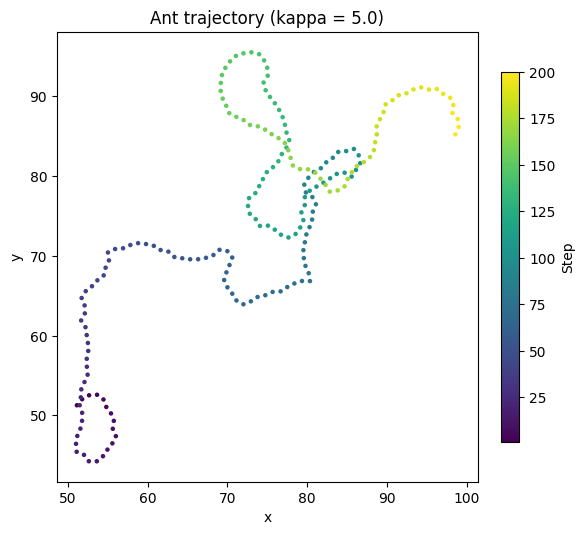

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot(results.x, results.y, lw=1, color="0.8", label="path")
scatter = ax.scatter(
    results.x,
    results.y,
    c=results.index.get_level_values("Step"),
    cmap="viridis",
    s=5,
)
fig.colorbar(scatter, ax=ax, label="Step", shrink=0.8, fraction=0.045)
ax.set(title="Ant trajectory (kappa = 5.0)", xlabel="x", ylabel="y")
# ax.set_xlim(20, 80)
# ax.set_ylim(20, 80)
ax.set_aspect("equal")
plt.show()

## 4 Exercises

Work in small groups. Discuss *before* running code.


### Exercise 1 — Turning concentration
Vary the `kappa` parameter (e.g. 1, 2, 5, 10) and **plot** the resulting trajectories.
1. How does increasing $\kappa$ change the *qualitative* shape of the path?
2. Suggest a biological scenario corresponding to *low* vs *high* $\kappa$.



## 5 Batch simulations
The helper function `mesa.batch_run` launches multiple, independent realizations of the model.
Each run is identified by two extra columns in the output DataFrame: `Run` and `Iteration`.


In [17]:
BATCH_PARAMS = {
    "n_ants": [2, 3, 6],  # try different colony sizes
    "kappa": [5.0],       # keep turning stiffness fixed for now
}

batch_results = mesa.batch_run(
    AntModel,
    parameters=BATCH_PARAMS,
    iterations=20,         # replicate each parameter set 20 times
    max_steps=200,
    number_processes=1,    # set >1 for parallel execution on multi‑core machines
    data_collection_period=1,  # collect at every step (required for MSD)
    display_progress=True,
)

batch_results = pd.DataFrame(batch_results)
batch_results.dropna(inplace=True)
batch_results.head()



  0%|          | 0/60 [00:00<?, ?it/s]

,RunId,iteration,Step,n_ants,kappa,AgentID,x,y,heading
1,0,0,1,2,5.0,1.0,49.530131,50.256374,-1.954141
2,0,0,1,2,5.0,2.0,50.662162,49.513236,4.496044
3,0,0,2,2,5.0,1.0,49.156107,49.328955,-1.648051
4,0,0,2,2,5.0,2.0,50.447501,48.536547,4.808444
5,0,0,3,2,5.0,1.0,49.078929,48.331937,4.562891


With the raw table in hand, we can compute ensemble statistics.
For example, the mean‑squared displacement (MSD):


In [18]:
def _msd(traj: pd.DataFrame) -> pd.Series:
    """Compute MSD(t) for one realisation."""
    # Initial positions per AgentID (level="AgentID")
    x0 = traj["x"].groupby(level="AgentID").transform("first")
    y0 = traj["y"].groupby(level="AgentID").transform("first")

    dx = traj["x"] - x0
    dy = traj["y"] - y0

    return (dx ** 2 + dy ** 2).groupby(level="Step").mean()

# Compute MSD for every (n_ants, Iteration) combo, then average over iterations
msd_list = []
for (n_ants, iteration), df in batch_results.groupby(["n_ants", "iteration"]):
    df = df.set_index(["Step", "AgentID"]).sort_index()
    msd = _msd(df)
    msd_list.append(
        pd.DataFrame({
            "Step": msd.index,
            "MSD": msd.values,
            "n_ants": n_ants,
            "Iteration": iteration,
        })
    )
msd_df = pd.concat(msd_list, ignore_index=True)

# Ensemble average over iterations
msd_mean = msd_df.groupby(["n_ants", "Step"], as_index=False)["MSD"].mean()


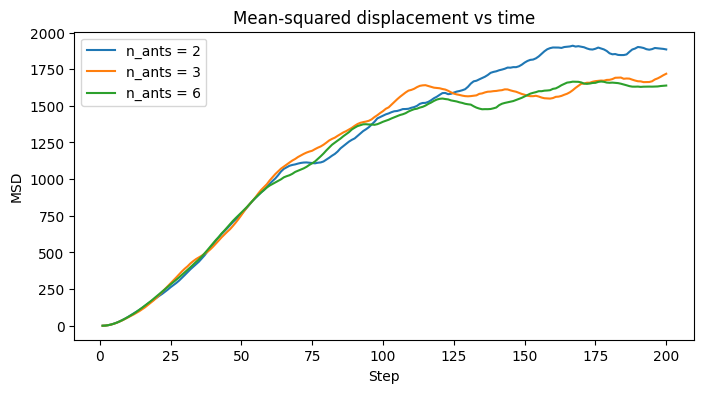

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
for n, sub in msd_mean.groupby("n_ants"):
    ax.plot(sub["Step"], sub["MSD"], label=f"n_ants = {n}")
ax.set_xlabel("Step")
ax.set_ylabel("MSD")
ax.set_title("Mean‑squared displacement vs time")
ax.legend()
plt.show()


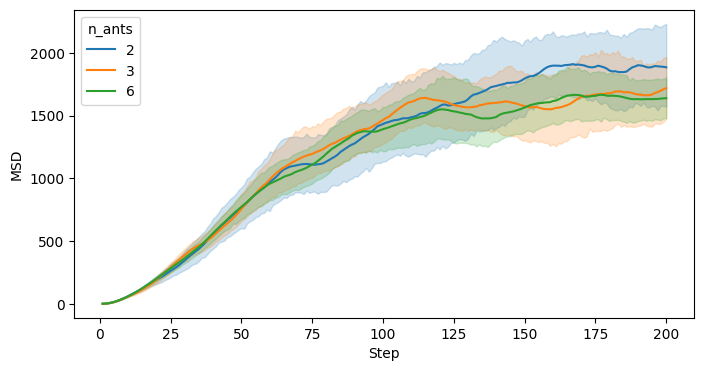

In [20]:
g = sns.lineplot(
    data=msd_df,
    x="Step",
    y="MSD",
    hue="n_ants",
    errorbar=("ci", 95),
    palette="tab10",
)
g.figure.set_size_inches(8, 4)

plt.show()


## 6 Exercises

Work in small groups. Discuss *before* running code.

### Exercise 2
1. Re‑run the batch for **at least five** $\kappa$ values (array above).
2. Compute the mean‑squared displacement for each $\kappa$ (average over **all** iterations).
3. Plot MSD vs. time (one curve per $\kappa$).

### Exercise 3
Plot a histogram of ant headings for different $\kappa$ values.

### Exercise 4 (optional)
Use a heatmap to visualize the distribution of ants at each timestep.